In [68]:
import unicodedata
import re
import json
import nltk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as m
import acquire_dr
import prepare_dr
#import prepare_jag

from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords
from time import strftime
from wordcloud import WordCloud
from pprint import pprint
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score

In [2]:
df = pd.read_csv('raw_data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151 entries, 0 to 150
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Unnamed: 0       151 non-null    int64 
 1   repo             151 non-null    object
 2   language         143 non-null    object
 3   readme_contents  147 non-null    object
dtypes: int64(1), object(3)
memory usage: 4.8+ KB


In [3]:
df.language.value_counts()

Swift               65
Python              38
C++                 15
C                   11
JavaScript           2
Java                 2
Jupyter Notebook     2
HTML                 2
Dockerfile           1
Markdown             1
Shell                1
R                    1
Starlark             1
LLVM                 1
Name: language, dtype: int64

In [4]:
df[df.language.isnull()]

,Unnamed: 0,repo,language,readme_contents
0,0,apple/llvm-project,NaN,# Apple's fork of llvm-project\n\nThis is Appl...
13,13,apple/swift-docc-render-artifact,NaN,# Swift-DocC-Render-Artifact\n\nThis repositor...
14,14,apple/swift-lmdb,NaN,# CLMDB\n\nCLMDB is a SwiftPM package wrapper ...
83,83,apple/swift-community-hosted-continuous-integr...,NaN,# Swift Community-Hosted Continuous Integratio...
123,123,apple/ml-transcript-translation-consistency-ra...,NaN,# Human Ratings of Transcription/Translation C...
139,139,apple/llvm-monorepo-root,NaN,# Disclaimer\n\nThe [llvm-monorepo-root](https...
145,145,apple/swift-protobuf-plugin,NaN,"<img src=""https://swift.org/assets/images/swif..."
149,149,apple/swift-protobuf-test-conformance,NaN,"<img src=""https://swift.org/assets/images/swif..."


#### Observations:

- There are some repositories lacking a specified language, not sure how to proceed there but there's only 8 rows missing languages
    - an idea is to infer the language based on the repository title
- llvm project does not specify language but readme states the repo contains source code for LLVM, so go with `LLVM`?
- swift docc render artifact does not specify language but the readme states that the repository holds a pre-built copy of the swift docc render repo, which is majority `javascript`
- swift imdb is `C`, not sure why the acquire function didn't pick it up
- swift community hosted continuous integration is an extension of Swift ci which allows community memberts to add platforms.
    - Seems like the most recent uploads to the swift ci site are `swift` based files.
- ml transcript translation's repo looks like is just csv files
- llvm monorepo root is a wip repository for apple's open source `Swift` project.
- swift protobuf plugin was combined under the swift-protobuf repo, which is majority `swift` programming language
- swift protobuf test conformance was combined under the swift-protobuf repo, which is majority `swift` programming language

In [5]:
df[df.index == 83].repo

83    apple/swift-community-hosted-continuous-integr...
Name: repo, dtype: object

In [6]:
nan_languages = list(df[df.language.isnull()].index)

In [7]:
for i in nan_languages:
    display(df[df.index == i])

,Unnamed: 0,repo,language,readme_contents
0,0,apple/llvm-project,NaN,# Apple's fork of llvm-project\n\nThis is Appl...


,Unnamed: 0,repo,language,readme_contents
13,13,apple/swift-docc-render-artifact,NaN,# Swift-DocC-Render-Artifact\n\nThis repositor...


,Unnamed: 0,repo,language,readme_contents
14,14,apple/swift-lmdb,NaN,# CLMDB\n\nCLMDB is a SwiftPM package wrapper ...


,Unnamed: 0,repo,language,readme_contents
83,83,apple/swift-community-hosted-continuous-integr...,NaN,# Swift Community-Hosted Continuous Integratio...


,Unnamed: 0,repo,language,readme_contents
123,123,apple/ml-transcript-translation-consistency-ra...,NaN,# Human Ratings of Transcription/Translation C...


,Unnamed: 0,repo,language,readme_contents
139,139,apple/llvm-monorepo-root,NaN,# Disclaimer\n\nThe [llvm-monorepo-root](https...


,Unnamed: 0,repo,language,readme_contents
145,145,apple/swift-protobuf-plugin,NaN,"<img src=""https://swift.org/assets/images/swif..."


,Unnamed: 0,repo,language,readme_contents
149,149,apple/swift-protobuf-test-conformance,NaN,"<img src=""https://swift.org/assets/images/swif..."


In [8]:
# let's override the languages with the observations noted
df.language.loc[0] = 'LLVM'
df.language.loc[13] = 'JavaScript'
df.language.loc[14] = 'C'
df.language.loc[83] = 'Swift'
df.language.loc[139] = 'Swift'
df.language.loc[145] = 'Swift'
df.language.loc[149] = 'Swift'

/Users/davidrodriguez/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [9]:
df.language.loc[0]

'LLVM'

In [10]:
df[df.language.isnull()]

,Unnamed: 0,repo,language,readme_contents
123,123,apple/ml-transcript-translation-consistency-ra...,NaN,# Human Ratings of Transcription/Translation C...


In [11]:
df[df.readme_contents.isnull()]

,Unnamed: 0,repo,language,readme_contents
114,114,apple/darwin-libplatform,C,NaN
135,135,apple/swift-libcxx,C++,NaN
144,144,apple/ccs-pyopendirectory,C++,NaN
150,150,apple/darwin-libpthread,C,NaN


In [12]:
df.dropna(inplace = True)
df.shape

(146, 4)

In [13]:
# let's map the less common languages to 'other' and consolidate the different c's into one
# language
df.language.value_counts()

Swift               69
Python              38
C++                 13
C                   10
JavaScript           3
LLVM                 2
Java                 2
Jupyter Notebook     2
HTML                 2
Dockerfile           1
Markdown             1
Shell                1
R                    1
Starlark             1
Name: language, dtype: int64

In [14]:
df['language']= df.language.map({'Swift': 'Swift', 'Python': 'Python', 'C++':'C', 'C': 'C',
                                 'JavaScript':'Other', 'LLVM':'Other', 'Java':'Other', 
                                 'Jupyter Notebook':'Other', 'HTML':'Other', 'Dockerfile':'Other', 
                                 'Markdown':'Other', 'Shell':'Other', 'R':'Other', 'Starlark':'Other'})

In [15]:
df.language.value_counts()

Swift     69
Python    38
C         23
Other     16
Name: language, dtype: int64

In [16]:
extra_words = ['the', 'to', 'a', 'and', 'of', 'in', 'for', 'is']

In [17]:
#extra_words

In [18]:
i = 0
for readme in df.readme_contents:
    df.readme_contents.loc[i] = prepare_dr.basic_clean(readme)
    i = i + 1

/Users/davidrodriguez/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [19]:
#i = 0

#for readme in df.readme_contents:
#    df.readme_contents.loc[i] = prepare_dr.tokenize(readme)
#    i = i + 1

In [20]:
i = 0

for readme in df.readme_contents:
    df.readme_contents.loc[i] = prepare_dr.stem(readme)
    i = i + 1

In [21]:
#i = 0

#for readme in df.readme_contents:
#    df.readme_contents.loc[i] = prepare_dr.lemmatize(readme)
#    i = i + 1

In [22]:
#i = 0
    
#for readme in df.readme_contents:
#    df.readme_contents.loc[i] = prepare_dr.remove_stopwords(readme)
#    i = i + 1

In [23]:
i = 0
    
for readme in df.readme_contents:
    df.readme_contents.loc[i] = prepare_dr.remove_stopwords(readme, extra_words)
    i = i + 1

In [24]:
df.readme_contents.loc[10]

'swift sourc compat suit sourc compat strong goal futur swift releas aid thi goal commun sourc compat test suit serv regress test chang compil gradual increas corpu swift sourc code project ad thi test suit period built latest develop version swift part swift continu integr system http ci swift org allow swift compil develop understand compat impact chang real world swift project current list project href http swift org sourc compat current list project current list project view swift org ad project swift sourc compat test suit commun driven mean open sourc swift project owner encourag submit project meet accept criteria inclus test suit project ad suit serv gener sourc compat test afford greater protect unintent sourc breakag futur swift releas accept criteria accept swift sourc compat test suit project must 1 target linux maco io tvo watcho devic 2 xcode swift packag manag project carthag cocoapod current unsupport explor support futur 3 support build either linux maco 4 contain publ

In [25]:
df.drop(columns = 'Unnamed: 0', inplace = True)

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 146 entries, 0 to 149
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   repo             146 non-null    object
 1   language         146 non-null    object
 2   readme_contents  146 non-null    object
dtypes: object(3)
memory usage: 8.6+ KB


In [27]:
df.head()

,repo,language,readme_contents
0,apple/llvm-project,Other,appl fork llvm project thi appl fork llvm proj...
1,apple/swift-argument-parser,Swift,swift argument parser usag begin declar type d...
2,apple/swift-docc,Swift,swift docc swift docc document compil swift fr...
3,apple/swift,C,img src http swift org asset imag swift svg al...
4,apple/sourcekit-lsp,Swift,sourcekit lsp sourcekit lsp implement languag ...


In [28]:
language = pd.concat([df.language.value_counts(), df.language.value_counts(normalize = True)], axis = 1)
language.columns = ['n', 'percent']
language

,n,percent
Swift,69,0.472603
Python,38,0.260274
C,23,0.157534
Other,16,0.109589


In [29]:
swift_words = ' '.join(df[df.language == 'Swift'].readme_contents).split()
python_words = ' '.join(df[df.language == 'Python'].readme_contents).split()
c_words = ' '.join(df[df.language == 'C'].readme_contents).split()
other_words = ' '.join(df[df.language == 'Other'].readme_contents).split()
all_words = ' '.join(df.readme_contents).split()

In [30]:
swift_freq = pd.Series(swift_words).value_counts()
python_freq = pd.Series(python_words).value_counts()
c_freq = pd.Series(c_words).value_counts()
other_freq = pd.Series(other_words).value_counts()
all_freq = pd.Series(all_words).value_counts()

In [31]:
word_counts = (pd.concat([all_freq, swift_freq, python_freq, c_freq, other_freq], axis = 1, sort = True)
                .set_axis(['all', 'swift', 'python', 'c', 'other'], axis = 1, inplace = False)
                .fillna(0)
                .apply(lambda s: s.astype(int)))

word_counts.head()

,all,swift,python,c,other
"""LICENSE""",3,1,2,0,0
"""license""",1,0,1,0,0
"""owned""",3,1,2,0,0
"""s""",3,1,2,0,0
#,3,2,1,0,0


In [32]:
word_counts.sort_values(by = 'all', ascending = False).head(10)

,all,swift,python,c,other
swift,2277,1694,79,329,175
http,1223,681,184,210,148
use,1051,556,241,179,75
thi,902,502,209,107,84
build,638,320,42,228,48
com,599,400,68,65,66
appl,583,404,39,83,57
packag,556,417,30,86,23
github,554,390,52,59,53
org,481,196,78,134,73


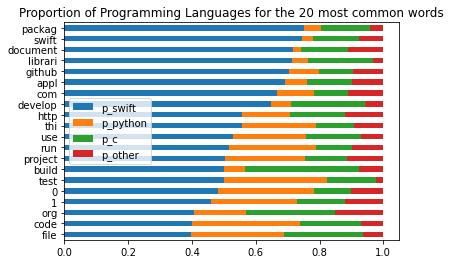

In [33]:
# figure out the percentage of spam vs ham
(word_counts
 .assign(p_swift = word_counts.swift / word_counts['all'],
         p_python = word_counts.python / word_counts['all'],
         p_c = word_counts.c / word_counts['all'],
         p_other = word_counts.other / word_counts['all'])
 .sort_values(by = 'all')
 [['p_swift', 'p_python', 'p_c', 'p_other']]
 .tail(20)
 .sort_values('p_swift')
 .plot.barh(stacked=True))

plt.title('Proportion of Programming Languages for the 20 most common words');

In [34]:
top_20_swift_bigrams = (pd.Series(nltk.ngrams(swift_words, 2))
                      .value_counts()
                      .head(20))

top_20_swift_bigrams.head()

(github, com)     337
(http, github)    332
(com, appl)       271
(appl, swift)     270
(swift, org)      152
dtype: int64

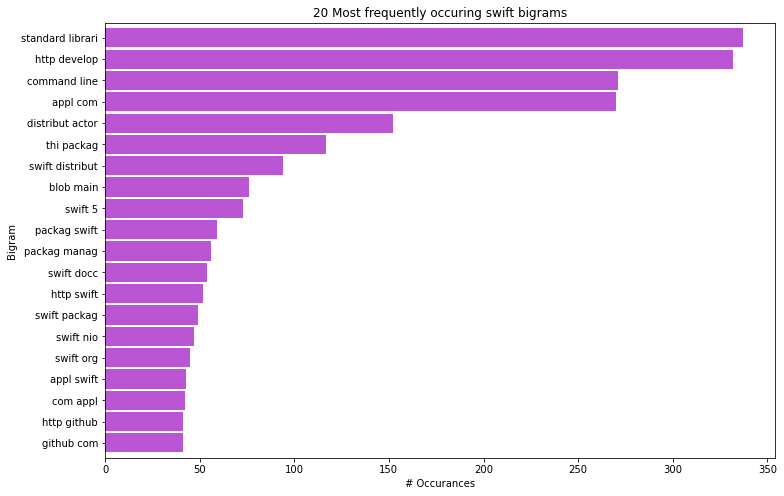

In [35]:
top_20_swift_bigrams.sort_values().plot.barh(color = 'mediumorchid', width=.9, figsize=(12, 8))

plt.title('20 Most frequently occuring swift bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_swift_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)


In [36]:
top_20_python_bigrams = (pd.Series(nltk.ngrams(python_words, 2))
                      .value_counts()
                      .head(20))

top_20_python_bigrams.head()

(github, com)      38
(http, github)     37
(python, tool)     32
(code, python)     31
(data, paramet)    30
dtype: int64

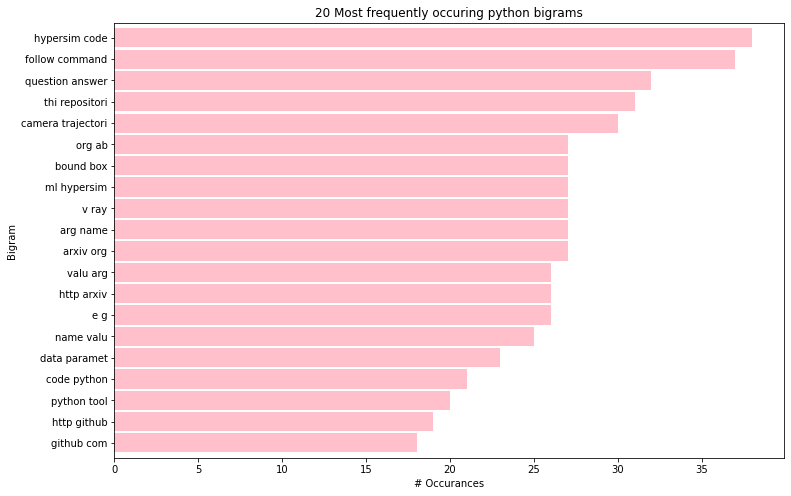

In [37]:
top_20_python_bigrams.sort_values().plot.barh(color = 'pink', width = .9, figsize = (12, 8))

plt.title('20 Most frequently occuring python bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_python_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)


In [38]:
top_20_c_bigrams = (pd.Series(nltk.ngrams(c_words, 2))
                      .value_counts()
                      .head(20))

top_20_c_bigrams.head()

(swift, org)       95
(swift, crypto)    50
(http, ci)         46
(oss, swift)       44
(job, oss)         44
dtype: int64

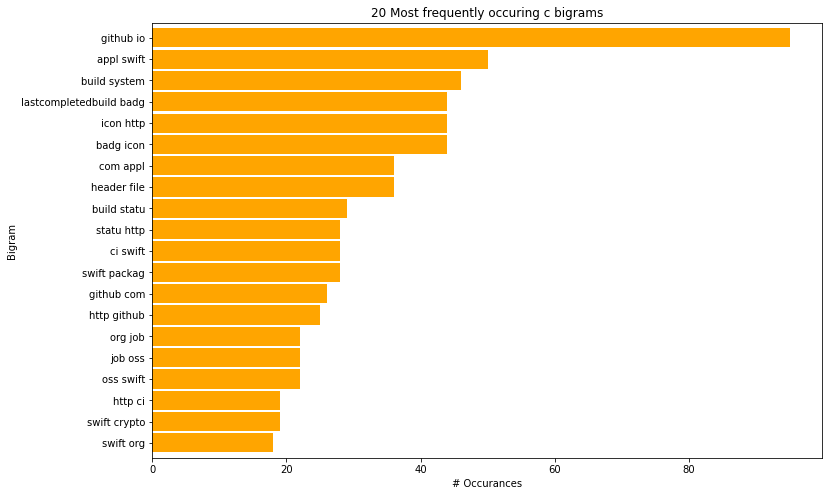

In [39]:
top_20_c_bigrams.sort_values().plot.barh(color = 'orange', width=.9, figsize=(12, 8))

plt.title('20 Most frequently occuring c bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_c_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)


In [40]:
top_20_other_bigrams = (pd.Series(nltk.ngrams(other_words, 2))
                      .value_counts()
                      .head(20))

top_20_other_bigrams.head()

(github, com)     42
(http, github)    41
(swift, org)      39
(swift, docc)     30
(com, appl)       29
dtype: int64

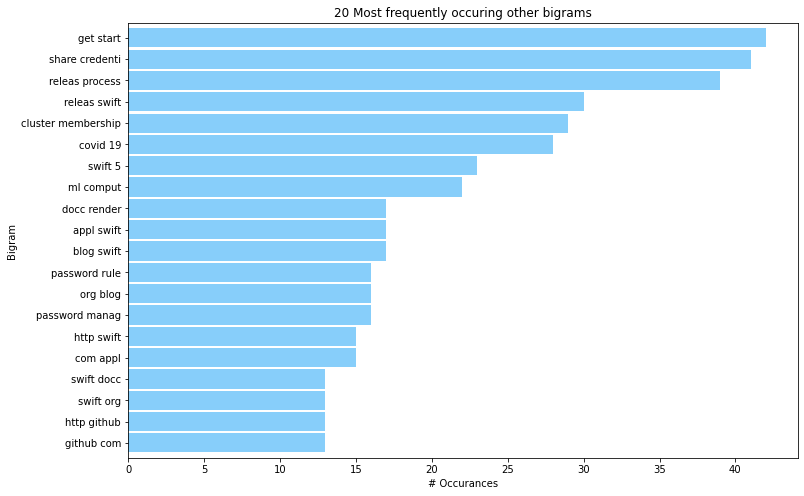

In [41]:
top_20_other_bigrams.sort_values().plot.barh(color = 'lightskyblue', width=.9, figsize=(12, 8))

plt.title('20 Most frequently occuring other bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_other_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)


In [42]:
top_20_all_bigrams = (pd.Series(nltk.ngrams(all_words, 2))
                      .value_counts()
                      .head(20))

top_20_all_bigrams.head()

(github, com)     453
(http, github)    446
(com, appl)       342
(appl, swift)     308
(swift, org)      296
dtype: int64

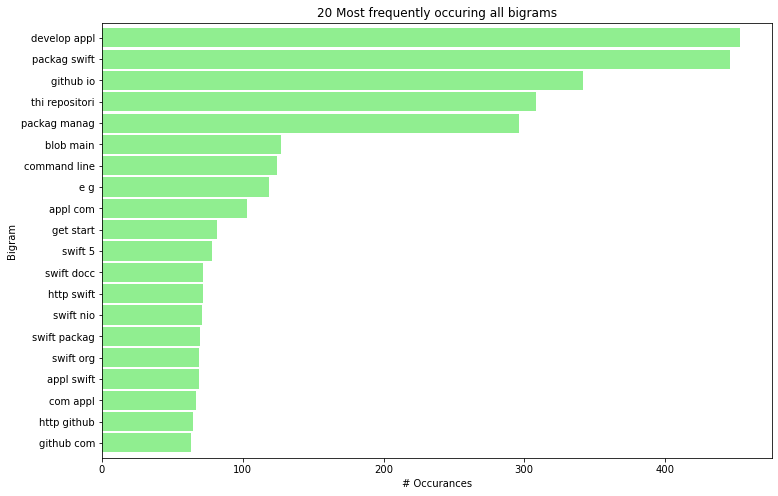

In [43]:
top_20_all_bigrams.sort_values().plot.barh(color = 'lightgreen', width=.9, figsize=(12, 8))

plt.title('20 Most frequently occuring all bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_all_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)


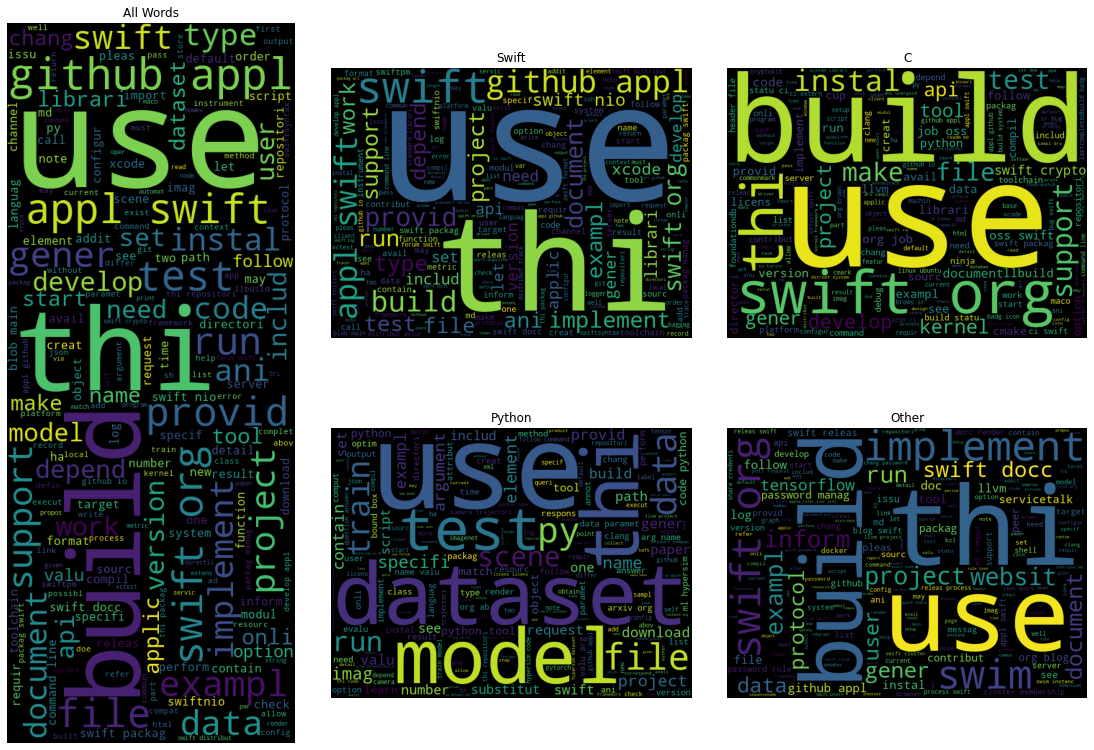

In [44]:
all_cloud = WordCloud(background_color = 'black', height = 1000, width = 400).generate(' '.join(all_words))
swift_cloud = WordCloud(background_color = 'black', height = 600, width = 800).generate(' '.join(swift_words))
python_cloud = WordCloud(background_color = 'black', height = 600, width = 800).generate(' '.join(python_words))
c_cloud = WordCloud(background_color = 'black', height = 600, width = 800).generate(' '.join(c_words))
other_cloud = WordCloud(background_color = 'black', height = 600, width = 800).generate(' '.join(other_words))

plt.figure(figsize = (10, 10))
axs = [plt.axes([0, 0, .5, 1]), plt.axes([.5, .5, .5, .5]), plt.axes([.5, 0, .5, .5]), plt.axes([1.05, .5, .5, .5]),
      plt.axes([1.05, 0, .5, .5])]

axs[0].imshow(all_cloud)
axs[1].imshow(swift_cloud)
axs[2].imshow(python_cloud)
axs[3].imshow(c_cloud)
axs[4].imshow(other_cloud)

axs[0].set_title('All Words')
axs[1].set_title('Swift')
axs[2].set_title('Python')
axs[3].set_title('C')
axs[4].set_title('Other')

for ax in axs: ax.axis('off')

In [45]:
# baseline
df[df['language'] == 'Swift'].language.value_counts()/sum(df.language.value_counts())

Swift    0.472603
Name: language, dtype: float64

In [105]:
eval_df = pd.DataFrame(columns = ['model_type', 'target_var', 'train_accuracy'])
eval_df

,model_type,target_var,train_accuracy


In [110]:
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(df.readme_contents)
y = df.language

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=.2)

train = pd.DataFrame(dict(actual=y_train))
test = pd.DataFrame(dict(actual=y_test))

lm = LogisticRegression().fit(X_train, y_train)

train['predicted'] = lm.predict(X_train)
test['predicted'] = lm.predict(X_test)

In [111]:
print('Accuracy: {:.2%}'.format(accuracy_score(train.actual, train.predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(train.predicted, train.actual))
print('---')
print(classification_report(train.actual, train.predicted))

Accuracy: 75.86%
---
Confusion Matrix
actual     C  Other  Python  Swift
predicted                         
C          7      0       0      0
Python     2      1      27      1
Swift      9     12       3     54
---
              precision    recall  f1-score   support

           C       1.00      0.39      0.56        18
       Other       0.00      0.00      0.00        13
      Python       0.87      0.90      0.89        30
       Swift       0.69      0.98      0.81        55

    accuracy                           0.76       116
   macro avg       0.64      0.57      0.56       116
weighted avg       0.71      0.76      0.70       116



/Users/davidrodriguez/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/davidrodriguez/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/davidrodriguez/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [112]:
eval_df = eval_df.append({'model_type':'Logistic Regression', 'target_var':'language', 'train_accuracy':accuracy_score(train.actual, train.predicted)}, ignore_index = True)
eval_df

,model_type,target_var,train_accuracy
0,Logistic Regression,language,0.758621


In [48]:
print('Accuracy: {:.2%}'.format(accuracy_score(test.actual, test.predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(test.predicted, test.actual))
print('---')
print(classification_report(test.actual, test.predicted))

Accuracy: 66.67%
---
Confusion Matrix
actual     C  Other  Python  Swift
predicted                         
Python     0      2       6      0
Swift      5      1       2     14
---
              precision    recall  f1-score   support

           C       0.00      0.00      0.00         5
       Other       0.00      0.00      0.00         3
      Python       0.75      0.75      0.75         8
       Swift       0.64      1.00      0.78        14

    accuracy                           0.67        30
   macro avg       0.35      0.44      0.38        30
weighted avg       0.50      0.67      0.56        30



/Users/davidrodriguez/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/davidrodriguez/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/davidrodriguez/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [115]:
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(df.readme_contents)
y = df.language

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=.2)

train = pd.DataFrame(dict(actual=y_train))
test = pd.DataFrame(dict(actual=y_test))

dtc = DecisionTreeClassifier(max_depth = 2).fit(X_train, y_train)

train['predicted'] = dtc.predict(X_train)
test['predicted'] = dtc.predict(X_test)

In [116]:
print('Accuracy: {:.2%}'.format(accuracy_score(train.actual, train.predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(train.predicted, train.actual))
print('---')
print(classification_report(train.actual, train.predicted))

Accuracy: 72.41%
---
Confusion Matrix
actual     C  Other  Python  Swift
predicted                         
C          4      0       1      0
Other      6      7       1      0
Python     3      1      22      4
Swift      5      5       6     51
---
              precision    recall  f1-score   support

           C       0.80      0.22      0.35        18
       Other       0.50      0.54      0.52        13
      Python       0.73      0.73      0.73        30
       Swift       0.76      0.93      0.84        55

    accuracy                           0.72       116
   macro avg       0.70      0.61      0.61       116
weighted avg       0.73      0.72      0.70       116



In [117]:
eval_df = eval_df.append({'model_type':'Decision Tree Classifier - max depth = 2', 'target_var':'language', 'train_accuracy':accuracy_score(train.actual, train.predicted)}, ignore_index = True)
eval_df

,model_type,target_var,train_accuracy
0,Logistic Regression,language,0.758621
1,Decision Tree Classifier - max depth = 2,language,0.724138


In [118]:
print('Accuracy: {:.2%}'.format(accuracy_score(test.actual, test.predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(test.predicted, test.actual))
print('---')
print(classification_report(test.actual, test.predicted))

Accuracy: 66.67%
---
Confusion Matrix
actual     C  Other  Python  Swift
predicted                         
Other      1      0       1      0
Python     2      2       6      0
Swift      2      1       1     14
---
              precision    recall  f1-score   support

           C       0.00      0.00      0.00         5
       Other       0.00      0.00      0.00         3
      Python       0.60      0.75      0.67         8
       Swift       0.78      1.00      0.88        14

    accuracy                           0.67        30
   macro avg       0.34      0.44      0.39        30
weighted avg       0.52      0.67      0.59        30



/Users/davidrodriguez/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/davidrodriguez/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/davidrodriguez/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [119]:
for i in range(3,11):
    dtc = DecisionTreeClassifier(max_depth = i).fit(X_train, y_train)

    train['predicted'] = dtc.predict(X_train)
    test['predicted'] = dtc.predict(X_test)
    
    print('Decision Tree Depth =', i)
    print('Accuracy: {:.2%}'.format(accuracy_score(train.actual, train.predicted)))
    print('---')
    print('Train Data - Confusion Matrix')
    print(pd.crosstab(train.predicted, train.actual))
    print('---')
    print(classification_report(train.actual, train.predicted))
    
    print('Decision Tree Depth =', i)
    print('Accuracy: {:.2%}'.format(accuracy_score(test.actual, test.predicted)))
    print('---')
    print('Test Data - Confusion Matrix')
    print(pd.crosstab(test.predicted, test.actual))
    print('---')
    print(classification_report(test.actual, test.predicted))
    print('------------------------------------------------------')
    
    eval_df = eval_df.append({'model_type':'Decision Tree Classifier - max depth = {}'.format(i), 'target_var':'language', 'train_accuracy':accuracy_score(train.actual, train.predicted)}, ignore_index = True)


Decision Tree Depth = 3
Accuracy: 80.17%
---
Train Data - Confusion Matrix
actual      C  Other  Python  Swift
predicted                          
C          12      1       3      3
Other       1     10       2      0
Python      0      0      20      1
Swift       5      2       5     51
---
              precision    recall  f1-score   support

           C       0.63      0.67      0.65        18
       Other       0.77      0.77      0.77        13
      Python       0.95      0.67      0.78        30
       Swift       0.81      0.93      0.86        55

    accuracy                           0.80       116
   macro avg       0.79      0.76      0.77       116
weighted avg       0.81      0.80      0.80       116

Decision Tree Depth = 3
Accuracy: 53.33%
---
Test Data - Confusion Matrix
actual     C  Other  Python  Swift
predicted                         
C          1      1       5      0
Other      1      0       1      0
Python     1      1       1      0
Swift      2      1  

/Users/davidrodriguez/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/davidrodriguez/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/davidrodriguez/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Use

Decision Tree Depth = 6
Accuracy: 97.41%
---
Train Data - Confusion Matrix
actual      C  Other  Python  Swift
predicted                          
C          17      0       0      0
Other       0     13       0      1
Python      0      0      29      0
Swift       1      0       1     54
---
              precision    recall  f1-score   support

           C       1.00      0.94      0.97        18
       Other       0.93      1.00      0.96        13
      Python       1.00      0.97      0.98        30
       Swift       0.96      0.98      0.97        55

    accuracy                           0.97       116
   macro avg       0.97      0.97      0.97       116
weighted avg       0.98      0.97      0.97       116

Decision Tree Depth = 6
Accuracy: 50.00%
---
Test Data - Confusion Matrix
actual     C  Other  Python  Swift
predicted                         
C          1      0       3      1
Python     1      2       1      0
Swift      3      1       4     13
---
              pre

/Users/davidrodriguez/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/davidrodriguez/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/davidrodriguez/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Use

              precision    recall  f1-score   support

           C       0.00      0.00      0.00         5
       Other       0.00      0.00      0.00         3
      Python       0.40      0.25      0.31         8
       Swift       0.61      1.00      0.76        14

    accuracy                           0.53        30
   macro avg       0.25      0.31      0.27        30
weighted avg       0.39      0.53      0.44        30

------------------------------------------------------
Decision Tree Depth = 8
Accuracy: 100.00%
---
Train Data - Confusion Matrix
actual      C  Other  Python  Swift
predicted                          
C          18      0       0      0
Other       0     13       0      0
Python      0      0      30      0
Swift       0      0       0     55
---
              precision    recall  f1-score   support

           C       1.00      1.00      1.00        18
       Other       1.00      1.00      1.00        13
      Python       1.00      1.00      1.00        

/Users/davidrodriguez/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/davidrodriguez/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/davidrodriguez/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Use

In [120]:
eval_df

,model_type,target_var,train_accuracy
0,Logistic Regression,language,0.758621
1,Decision Tree Classifier - max depth = 2,language,0.724138
2,Decision Tree Classifier - max depth = 3,language,0.801724
3,Decision Tree Classifier - max depth = 4,language,0.887931
4,Decision Tree Classifier - max depth = 5,language,0.948276
5,Decision Tree Classifier - max depth = 6,language,0.974138
6,Decision Tree Classifier - max depth = 7,language,0.974138
7,Decision Tree Classifier - max depth = 8,language,1.000000
8,Decision Tree Classifier - max depth = 9,language,1.000000
9,Decision Tree Classifier - max depth = 10,language,1.000000


In [121]:
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(df.readme_contents)
y = df.language

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=.2)

train = pd.DataFrame(dict(actual=y_train))
test = pd.DataFrame(dict(actual=y_test))

rf = RandomForestClassifier(bootstrap = True, 
                            class_weight = None, 
                            criterion = 'gini',
                            min_samples_leaf = 3,
                            n_estimators = 100,
                            max_depth = 8, 
                            random_state = 123).fit(X_train, y_train)

train['predicted'] = rf.predict(X_train)
test['predicted'] = rf.predict(X_test)

In [122]:
print('Accuracy: {:.2%}'.format(accuracy_score(train.actual, train.predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(train.predicted, train.actual))
print('---')
print(classification_report(train.actual, train.predicted))

Accuracy: 80.17%
---
Confusion Matrix
actual      C  Other  Python  Swift
predicted                          
C          10      0       0      0
Other       0      3       0      0
Python      3      1      27      2
Swift       5      9       3     53
---
              precision    recall  f1-score   support

           C       1.00      0.56      0.71        18
       Other       1.00      0.23      0.38        13
      Python       0.82      0.90      0.86        30
       Swift       0.76      0.96      0.85        55

    accuracy                           0.80       116
   macro avg       0.89      0.66      0.70       116
weighted avg       0.84      0.80      0.78       116



In [123]:
eval_df = eval_df.append({'model_type':'Random Forest Classifier - min samples = 3, max depth = 8', 'target_var':'language', 'train_accuracy':accuracy_score(train.actual, train.predicted)}, ignore_index = True)
eval_df

,model_type,target_var,train_accuracy
0,Logistic Regression,language,0.758621
1,Decision Tree Classifier - max depth = 2,language,0.724138
2,Decision Tree Classifier - max depth = 3,language,0.801724
3,Decision Tree Classifier - max depth = 4,language,0.887931
4,Decision Tree Classifier - max depth = 5,language,0.948276
5,Decision Tree Classifier - max depth = 6,language,0.974138
6,Decision Tree Classifier - max depth = 7,language,0.974138
7,Decision Tree Classifier - max depth = 8,language,1.000000
8,Decision Tree Classifier - max depth = 9,language,1.000000
9,Decision Tree Classifier - max depth = 10,language,1.000000


In [124]:
print('Accuracy: {:.2%}'.format(accuracy_score(test.actual, test.predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(test.predicted, test.actual))
print('---')
print(classification_report(test.actual, test.predicted))

Accuracy: 63.33%
---
Confusion Matrix
actual     C  Other  Python  Swift
predicted                         
Python     0      0       6      1
Swift      5      3       2     13
---
              precision    recall  f1-score   support

           C       0.00      0.00      0.00         5
       Other       0.00      0.00      0.00         3
      Python       0.86      0.75      0.80         8
       Swift       0.57      0.93      0.70        14

    accuracy                           0.63        30
   macro avg       0.36      0.42      0.38        30
weighted avg       0.49      0.63      0.54        30



/Users/davidrodriguez/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/davidrodriguez/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/davidrodriguez/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [99]:
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(df.readme_contents)
y = df.language

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=.2)

train = pd.DataFrame(dict(actual=y_train))
test = pd.DataFrame(dict(actual=y_test))

knn = KNeighborsClassifier(n_neighbors = 11).fit(X_train, y_train)

train['predicted'] = dtc.predict(X_train)
test['predicted'] = dtc.predict(X_test)

In [100]:
print('Accuracy: {:.2%}'.format(accuracy_score(train.actual, train.predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(train.predicted, train.actual))
print('---')
print(classification_report(train.actual, train.predicted))

Accuracy: 89.66%
---
Confusion Matrix
actual      C  Other  Python  Swift
predicted                          
C          15      1       1      1
Other       1     10       1      2
Python      2      1      27      0
Swift       0      1       1     52
---
              precision    recall  f1-score   support

           C       0.83      0.83      0.83        18
       Other       0.71      0.77      0.74        13
      Python       0.90      0.90      0.90        30
       Swift       0.96      0.95      0.95        55

    accuracy                           0.90       116
   macro avg       0.85      0.86      0.86       116
weighted avg       0.90      0.90      0.90       116



In [101]:
print('Accuracy: {:.2%}'.format(accuracy_score(test.actual, test.predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(test.predicted, test.actual))
print('---')
print(classification_report(test.actual, test.predicted))

Accuracy: 93.33%
---
Confusion Matrix
actual     C  Other  Python  Swift
predicted                         
C          5      0       0      1
Other      0      3       0      0
Python     0      0       8      1
Swift      0      0       0     12
---
              precision    recall  f1-score   support

           C       0.83      1.00      0.91         5
       Other       1.00      1.00      1.00         3
      Python       0.89      1.00      0.94         8
       Swift       1.00      0.86      0.92        14

    accuracy                           0.93        30
   macro avg       0.93      0.96      0.94        30
weighted avg       0.94      0.93      0.93        30



In [125]:
for i in range(2,13):
    knn = KNeighborsClassifier(n_neighbors = i).fit(X_train, y_train)

    train['predicted'] = dtc.predict(X_train)
    test['predicted'] = dtc.predict(X_test)
    
    print('Value of K =', i)
    print('Accuracy: {:.2%}'.format(accuracy_score(train.actual, train.predicted)))
    print('---')
    print('Train Data - Confusion Matrix')
    print(pd.crosstab(train.predicted, train.actual))
    print('---')
    print(classification_report(train.actual, train.predicted))
    
    print('Value of K =', i)
    print('Accuracy: {:.2%}'.format(accuracy_score(test.actual, test.predicted)))
    print('---')
    print('Test Data - Confusion Matrix')
    print(pd.crosstab(test.predicted, test.actual))
    print('---')
    print(classification_report(test.actual, test.predicted))
    print('------------------------------------------------------')
    
    eval_df = eval_df.append({'model_type':'KNN - neighbors = {}'.format(i), 'target_var':'language', 'train_accuracy':accuracy_score(train.actual, train.predicted)}, ignore_index = True)


Value of K = 2
Accuracy: 87.93%
---
Train Data - Confusion Matrix
actual      C  Other  Python  Swift
predicted                          
C          14      0       0      0
Other       1     10       1      0
Python      1      1      26      3
Swift       2      2       3     52
---
              precision    recall  f1-score   support

           C       1.00      0.78      0.88        18
       Other       0.83      0.77      0.80        13
      Python       0.84      0.87      0.85        30
       Swift       0.88      0.95      0.91        55

    accuracy                           0.88       116
   macro avg       0.89      0.84      0.86       116
weighted avg       0.88      0.88      0.88       116

Value of K = 2
Accuracy: 90.00%
---
Test Data - Confusion Matrix
actual     C  Other  Python  Swift
predicted                         
C          4      0       0      0
Other      0      3       0      0
Python     0      0       6      0
Swift      1      0       2     14
---


              precision    recall  f1-score   support

           C       1.00      0.78      0.88        18
       Other       0.83      0.77      0.80        13
      Python       0.84      0.87      0.85        30
       Swift       0.88      0.95      0.91        55

    accuracy                           0.88       116
   macro avg       0.89      0.84      0.86       116
weighted avg       0.88      0.88      0.88       116

Value of K = 8
Accuracy: 90.00%
---
Test Data - Confusion Matrix
actual     C  Other  Python  Swift
predicted                         
C          4      0       0      0
Other      0      3       0      0
Python     0      0       6      0
Swift      1      0       2     14
---
              precision    recall  f1-score   support

           C       1.00      0.80      0.89         5
       Other       1.00      1.00      1.00         3
      Python       1.00      0.75      0.86         8
       Swift       0.82      1.00      0.90        14

    accuracy  

In [126]:
eval_df

,model_type,target_var,train_accuracy
0,Logistic Regression,language,0.758621
1,Decision Tree Classifier - max depth = 2,language,0.724138
2,Decision Tree Classifier - max depth = 3,language,0.801724
3,Decision Tree Classifier - max depth = 4,language,0.887931
4,Decision Tree Classifier - max depth = 5,language,0.948276
5,Decision Tree Classifier - max depth = 6,language,0.974138
6,Decision Tree Classifier - max depth = 7,language,0.974138
7,Decision Tree Classifier - max depth = 8,language,1.000000
8,Decision Tree Classifier - max depth = 9,language,1.000000
9,Decision Tree Classifier - max depth = 10,language,1.000000


In [129]:
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(df.readme_contents)
y = df.language

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = .2)

train = pd.DataFrame(dict(actual=y_train))
test = pd.DataFrame(dict(actual=y_test))

SVC = LinearSVC(random_state=0, tol=1e-5).fit(X_train, y_train)

train['predicted'] = dtc.predict(X_train)
test['predicted'] = dtc.predict(X_test)

In [130]:
print('Accuracy: {:.2%}'.format(accuracy_score(train.actual, train.predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(train.predicted, train.actual))
print('---')
print(classification_report(train.actual, train.predicted))

Accuracy: 89.66%
---
Confusion Matrix
actual      C  Other  Python  Swift
predicted                          
C          15      0       0      0
Other       0     10       1      0
Python      1      1      26      2
Swift       2      2       3     53
---
              precision    recall  f1-score   support

           C       1.00      0.83      0.91        18
       Other       0.91      0.77      0.83        13
      Python       0.87      0.87      0.87        30
       Swift       0.88      0.96      0.92        55

    accuracy                           0.90       116
   macro avg       0.91      0.86      0.88       116
weighted avg       0.90      0.90      0.90       116



In [131]:
eval_df = eval_df.append({'model_type':'Linear SVC', 'target_var':'language', 'train_accuracy':accuracy_score(train.actual, train.predicted)}, ignore_index = True)
eval_df

,model_type,target_var,train_accuracy
0,Logistic Regression,language,0.758621
1,Decision Tree Classifier - max depth = 2,language,0.724138
2,Decision Tree Classifier - max depth = 3,language,0.801724
3,Decision Tree Classifier - max depth = 4,language,0.887931
4,Decision Tree Classifier - max depth = 5,language,0.948276
5,Decision Tree Classifier - max depth = 6,language,0.974138
6,Decision Tree Classifier - max depth = 7,language,0.974138
7,Decision Tree Classifier - max depth = 8,language,1.000000
8,Decision Tree Classifier - max depth = 9,language,1.000000
9,Decision Tree Classifier - max depth = 10,language,1.000000


In [77]:
print('Accuracy: {:.2%}'.format(accuracy_score(test.actual, test.predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(test.predicted, test.actual))
print('---')
print(classification_report(test.actual, test.predicted))

Accuracy: 90.00%
---
Confusion Matrix
actual     C  Other  Python  Swift
predicted                         
C          4      1       0      0
Other      1      2       1      0
Python     0      0       7      0
Swift      0      0       0     14
---
              precision    recall  f1-score   support

           C       0.80      0.80      0.80         5
       Other       0.50      0.67      0.57         3
      Python       1.00      0.88      0.93         8
       Swift       1.00      1.00      1.00        14

    accuracy                           0.90        30
   macro avg       0.82      0.84      0.83        30
weighted avg       0.92      0.90      0.91        30



In [95]:
for n in range(5, 11): 
    print('cv value =', n)
    print(cross_val_score(SVC, X_train, y_train, cv = n))

cv value = 5
[0.625      0.65217391 0.52173913 0.60869565 0.65217391]
cv value = 6
[0.65       0.6        0.52631579 0.68421053 0.57894737 0.63157895]
cv value = 7
[0.64705882 0.64705882 0.64705882 0.52941176 0.6875     0.625
 0.625     ]
cv value = 8
[0.6        0.6        0.73333333 0.46666667 0.71428571 0.57142857
 0.57142857 0.64285714]
cv value = 9
[0.61538462 0.69230769 0.76923077 0.61538462 0.46153846 0.76923077
 0.46153846 0.61538462 0.66666667]
cv value = 10
[0.66666667 0.66666667 0.66666667 0.66666667 0.5        0.58333333
 0.72727273 0.45454545 0.63636364 0.63636364]
